# Aknowledgement

The code which we use in our 'microGPT' example is taken to a large extent from **Andrej Karpathy**.

<img src="https://karpathy.ai/assets/me_new.jpg" at="Andrej Karpathy" width="200" height="100"/>


You find more information about and from him on his [personal website](https://karpathy.ai/). Here you find his original explanations and several interesting YouTube links, too. Check it out.

# Target definition

I announced that we would code our own 'microGPT'. This statement is somehow correct, but it might lead to expecting too much from this pocket project. We do not have a few thousand GPUs available for several weeks - just our laptops - nor the terabytes of training data. So we have to scale down the project and our expectations. In addition, we will not go through the fine-tuning phase, but will focus entirely on pre-training.

The goal of this project is to teach our model English. Remember, this is what pretraining is all about! Teaching the model to build correct English **sentences** would require it to cope with the English vocabulary - at least 50,000 words! We need to scale down our ambition and target for building correct English **words** instead. This allows us to reduce our vocabulary to the letters of the alphabet and the punctuation marks.

For our project, we will use the tinyShakespeare dataset, which is a collection of his works. Since English was different in Shakespeare's time than it is today, we should expect our model to create words that are used in Shakespeare's literature.

Please keep this in mind:
**Our goal is to build and train a language model that creates words in the English of Shakespeare's time!**

In [1]:
# Libraries we will use in this notebook
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
torch.manual_seed(1337)

# Preparation of dataset

## Load and check dataset

Let us start with downloading the dataset and reading it from the file into a string varable.

In [2]:
# import urllib.request
# 
# # Downloading the dataset from Andrej's github.
# # After successful download you will find the file 'input.txt' in the same directory as this jupyter notebook.
# 
# url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
# filename = "input.txt"
# 
# urllib.request.urlretrieve(url, filename)

In [3]:
# Here we assume that you have the file 'input.txt' in the same directory as this jupyter notebook.
# We load the complete content of 'input.txt' into the variable 'text'.

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# Let's see what we have in 'text'. How many characters?

print("Length of dataset in characters: ", format(len(text),','))

Length of dataset in characters:  1,115,394


In [5]:
# To get an impression of the file content, let's print out the first 300 characters.

print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


# Encode the training data (Tokenization)

Encoding is a step we haven't explicitly discussed in the theory part about transformers. In real world applications, encoding is an inherent part of tokenization. Remember, during tokenization the input sentenses are splitted into word fragments, punctuation marks or special codes like start or stop marks - the tokens. Internally, each token is represented by a number.

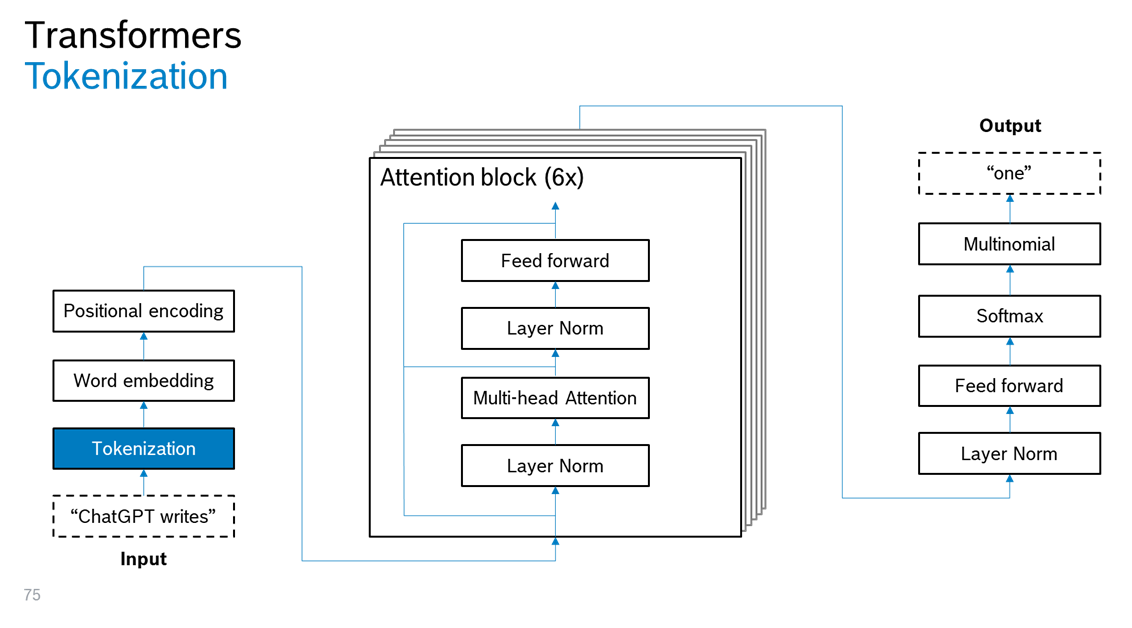

Since in our microGPT we do not deal with words but characters, we have no need to split sentences into tokens. Instead, we split words into characters and represent each character with a number.

## Define the vocabulary

The first task is to analyze the full dataset, the tinyShakespeare, to find all used characters. These characters are the population that our language model needs to know.

In [6]:
# Find a list of all unique characters in the text.
# The data type 'set' does not accept any double entries. Here we use this characteristic
# to get rid of all doubles.

chars = sorted(list(set(text)))
vocab_size = len(chars)

print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Define dictonaries

To proceed with encoding we represent each character with a unique integer. We define two dictonaries: char --> integer and integer --> char.

In [7]:
# Dictonary: Characters (s) to numbers (i)
stoi = { ch:i for i,ch in enumerate(chars) }

# Dictonary: Numbers (i) to characters (s)
itos = { i:ch for i,ch in enumerate(chars) }

## Encoding and decoding functions

In [8]:
# Encode character (s) to numbers (i)
encode = lambda s: [stoi[c] for c in s] # String to a list of numbers

# Decode numbers (i) to characters (s)
decode = lambda l: ''.join([itos[i] for i in l]) # List of numbers to string

In [9]:
# Test the encoder

enc = encode("Robert Bosch GmbH")
enc

[30, 53, 40, 43, 56, 58, 1, 14, 53, 57, 41, 46, 1, 19, 51, 40, 20]

In [10]:
# Test the decoder

decode(enc)

'Robert Bosch GmbH'

## Encode the full dataset

In [11]:
# Encode the full dataset

data = encode(text)
print(format(len(data),","))

1,115,394


In [12]:
# Print the first ten entries

data[:10]

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47]

In [13]:
# Load the encoding into a PyTorch tensor for further processing

data = torch.tensor(data, dtype=torch.long)

## Split the encoded dataset into training and validation dataset

In [14]:
# Train and test splits

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data feeder function

For the training process of our language model we need a function, that provides the model in each training loop with a batch of input data and the corresponding labels - the next character that the model is supposed to learn.

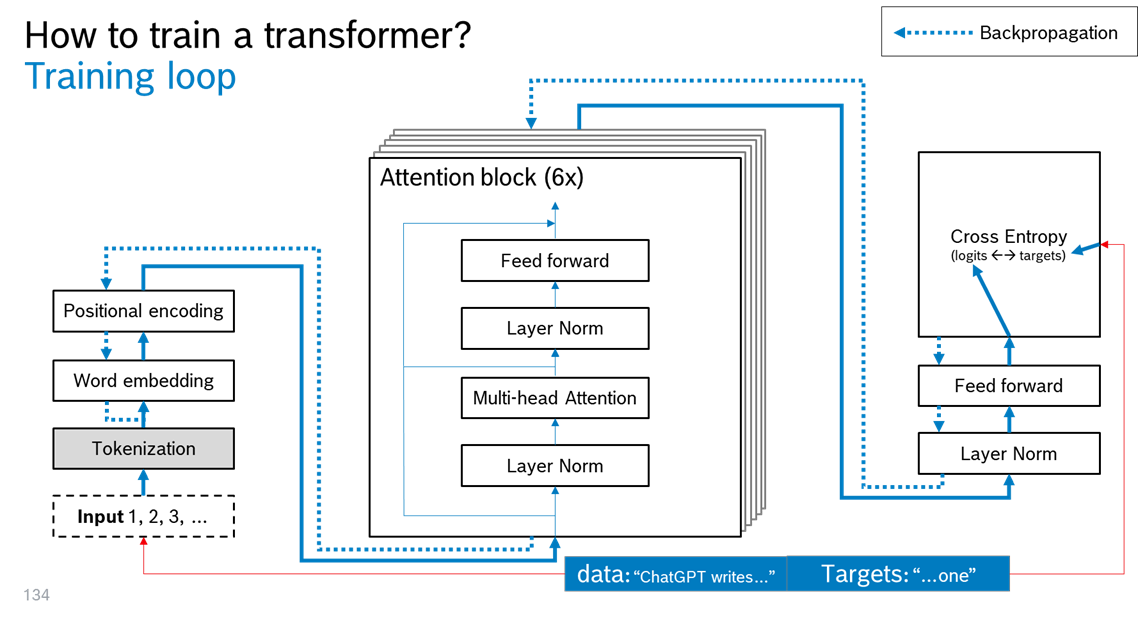

The idea is to randomly select a sequence of (encoded) characters from our dataset as the input to the model and the corresponding next character that follows the sequence as the target of learning. The length of the sequence of input characters is a hyperparameter and we name it '**block_size**'. Initially, we set the block_size to 256 characters. In order to make the training more efficient we do not feed the model a single character sequence in each training loop, but a '**batch_size**' many. We set the corresponding hyperparameter to 64, initially.

In [15]:
batch_size = 64 # Number of independent sequences we will process in parallel
block_size = 256 # Length of character sequences as context
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Use GPU instead of CPU, if available

# Function, that provides the model with a batch of training or validation data
# and the corresponding labels (the correct next characters)

def get_batch(split):
    """
    'split' is a string and either 'train' for training data or 
    'val' for validation data
    """
    # Define data source as training or validation data
    data = train_data if split == 'train' else val_data

    # Randomly choose initial positions in the dataset from 
    # where to start taking the sequence of 256 characters.
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 64 starting positions
    
    # Stack the selected sequences to a tensor of dimension 64 x 256
    x = torch.stack([data[i:i+block_size] for i in ix])

    # Same for the labels, but with an offset of 1 character
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    # Store x and y either on CPU or GPU, if available
    x, y = x.to(device), y.to(device)

    # Return x and y as the result of the 'get_batch' function
    return x, y

In [16]:
# Test our feeder function

input_data, labels = get_batch('train')
input_data.shape

torch.Size([64, 256])

In [17]:
input_data

tensor([[ 0, 26, 53,  ..., 56, 43, 47],
        [60, 43, 56,  ..., 56,  1, 41],
        [26, 21, 33,  ..., 26, 21, 13],
        ...,
        [ 5, 57,  1,  ...,  1, 35, 47],
        [56, 53, 53,  ..., 59, 50, 42],
        [42, 47, 56,  ..., 39, 56,  1]], device='cuda:0')

In [18]:
labels

tensor([[26, 53, 58,  ..., 43, 47, 45],
        [43, 56,  1,  ...,  1, 41, 53],
        [21, 33, 31,  ..., 21, 13, 10],
        ...,
        [57,  1, 52,  ..., 35, 47, 50],
        [53, 53, 58,  ..., 50, 42,  1],
        [47, 56, 43,  ..., 56,  1, 51]], device='cuda:0')

In [19]:
# Decode the first row of the input data back into English
print(decode(input_data.cpu().numpy()[0]))


Not Gloucester's death, nor Hereford's banishment
Not Gaunt's rebukes, nor England's private wrongs,
Nor the prevention of poor Bolingbroke
About his marriage, nor my own disgrace,
Have ever made me sour my patient cheek,
Or bend one wrinkle on my soverei


# Attention blocks

The majority of coding we do in microGPT is for the attention mechanism. Here, we will see a lot of nesting and looping because each of the functions is run several times.

## Single attention head

We start with coding a single **attention head**. The attention head is a mosaic piece of the multi-head attention which we covered in the theory part. The following image shows the attention head, depicted with 'Head 1', as part of the multi-head attention.

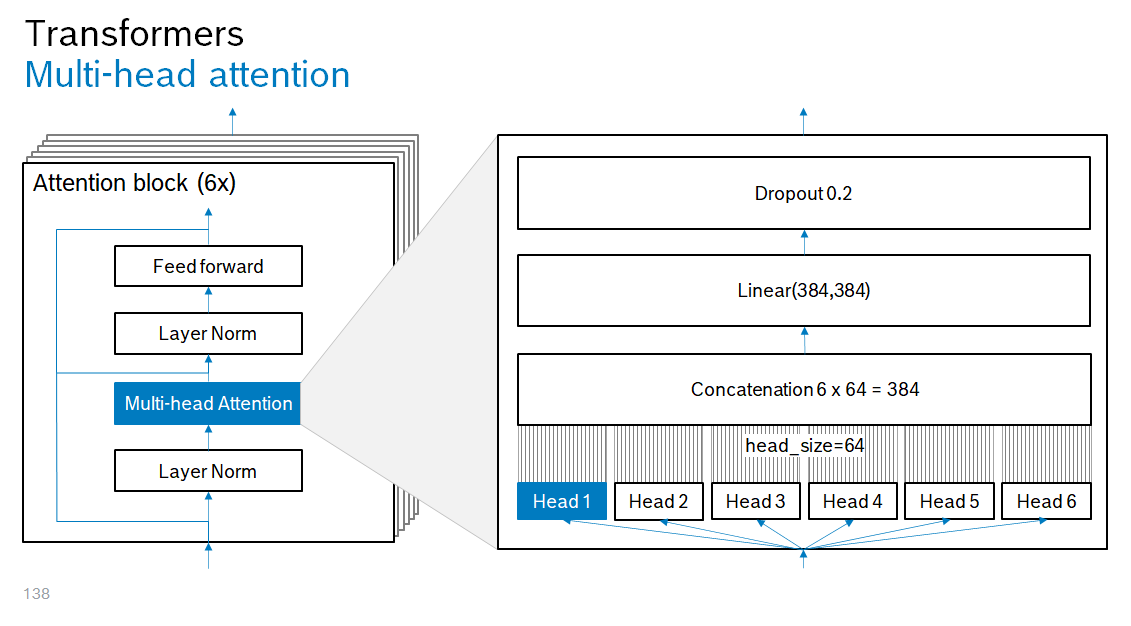

In the attention head we do the matrix operations which we covered in the deep dive video 'attention mechanism'.

As a reference, consider the matrix operations from the theory session on attention:

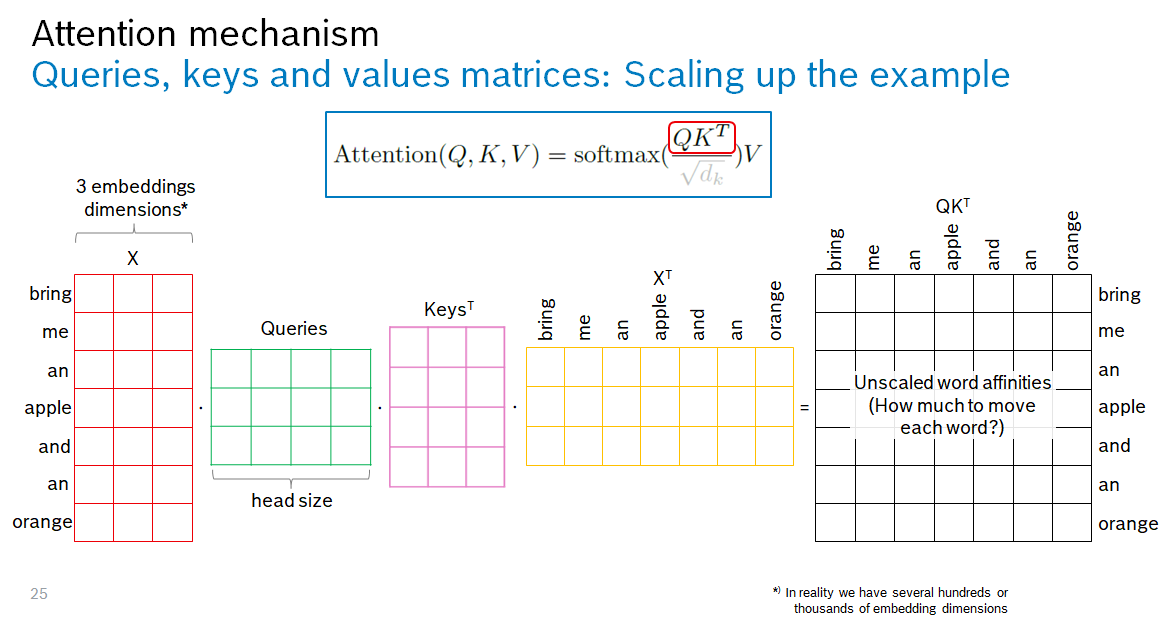

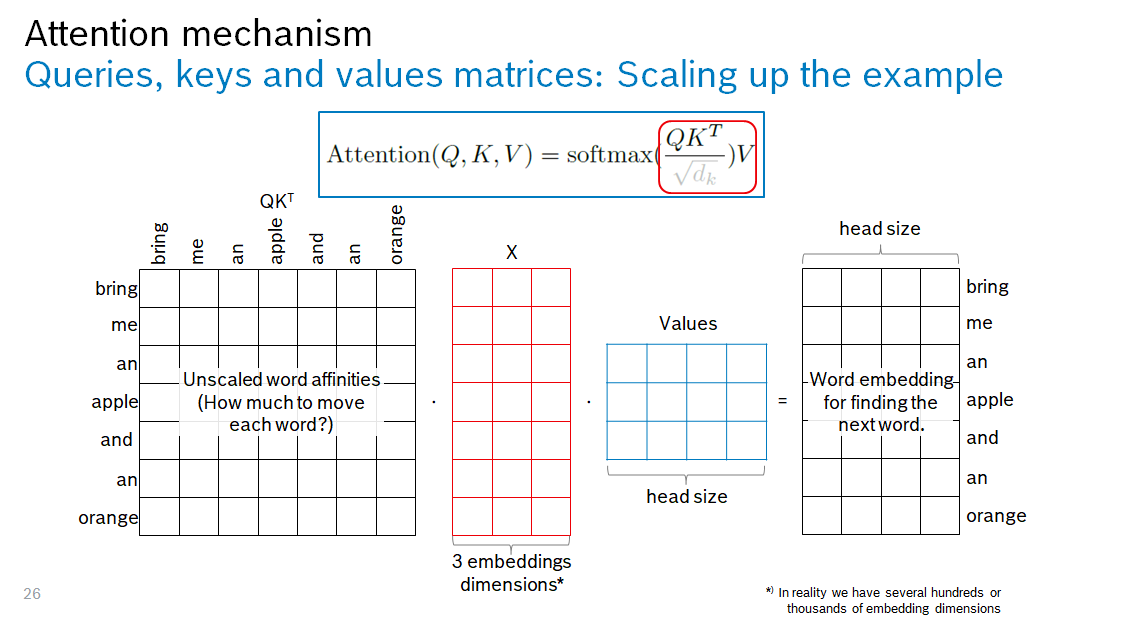

In [20]:
# More hyperparameters
n_embd = 384 # The embedding dimension for each token
dropout = 0.2 # The percentage of weights we set to 0 during training for regularization

# We construct a class for all the caluculations that are performed in the attention head.
# The class has two methods: __init__: It is run when we instantiate an object from the class
#                            forward:  It is run when we call an object from the class

class Head(nn.Module):
    """ Single head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # embedding x head_size
        self.query = nn.Linear(n_embd, head_size, bias=False) # embedding x head_size
        self.value = nn.Linear(n_embd, head_size, bias=False) # embedding x head_size
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # See below discourse
        self.dropout = nn.Dropout(dropout) # Ignore a portion of neurons per training loop --> prevent overfitting

    def forward(self, x):
        B,T,C = x.shape   # C=n_embd
        k = self.key(x)   # x @ key (B,T,H) | H=head_size
        q = self.query(x) # x @ query (B,T,H)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, H) @ (B, H, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) # Fill with '-inf' where template has 0
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # Perform the weighted aggregation of the values
        v = self.value(x) # x @ value (B,T,H)
        out = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)
        return out


## Discourse on 'register_buffer('tril',...)'

PyTorch's `register_buffer` is a kind of method used in the `nn.Module` class. The method safes a tensor to the module's state dictionary but does not consider theses tensors as model parameters during training - the tensor is not updated. Buffers are often used for storing running statistics that need to be saved and loaded with the model but are not updated through backpropagation.

In [21]:
B, T, C = (3, 4, 2) # Batch, Tokens, Embedding

# Example data
x = torch.randint(0,5,(B,T,C)).float()
x.shape

torch.Size([3, 4, 2])

In [22]:
x

tensor([[[3., 1.],
         [0., 2.],
         [4., 4.],
         [2., 4.]],

        [[0., 0.],
         [0., 3.],
         [3., 4.],
         [2., 2.]],

        [[3., 4.],
         [4., 1.],
         [1., 3.],
         [1., 4.]]])

In [23]:
# Define lower triangular matrix with 1s
tril = torch.tril(torch.ones(T,T))
tril

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [24]:
# Define a weight matrix
wei = torch.zeros((T, T))
wei

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [25]:
# Fill in '-inf' in wei whereever tril is 0
wei = wei.masked_fill(tril==0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

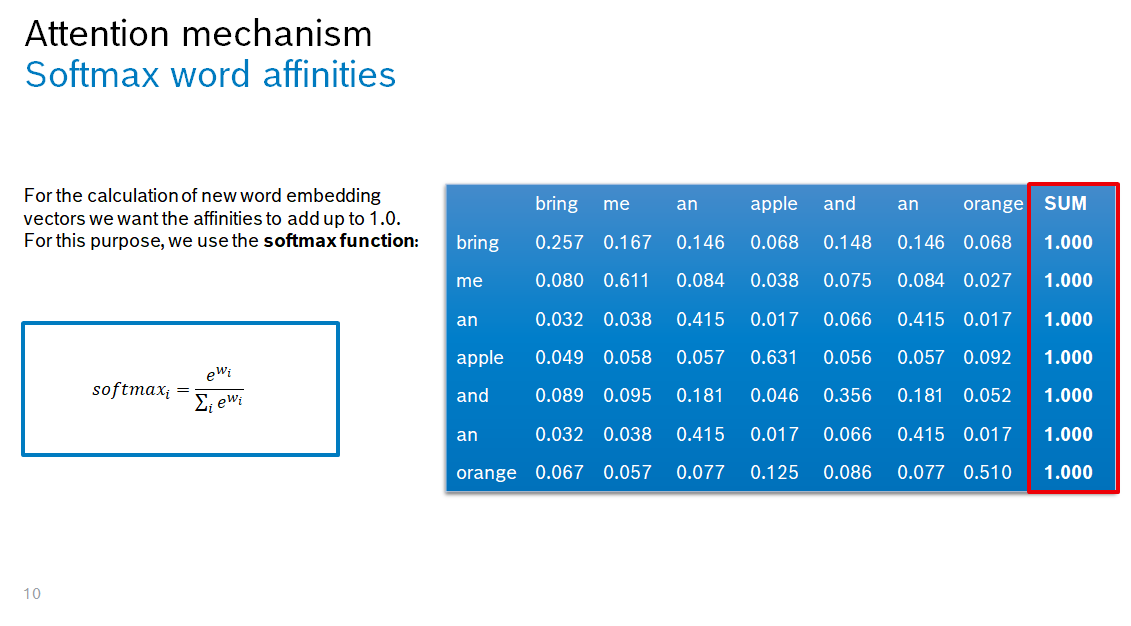

In [26]:
# Use softmax to calculate meaningful weights
wei = F.softmax(wei, dim=1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])

In [27]:
xbow = wei @ x
print(x[0].T)
xbow[0].T

tensor([[3., 0., 4., 2.],
        [1., 2., 4., 4.]])


tensor([[3.0000, 1.5000, 2.3333, 2.2500],
        [1.0000, 1.5000, 2.3333, 2.7500]])

We see that the multiplication allows us to calculate the average over the first one, two, three... embedding values. In the attention head code above we calculate `wei @ v`. This assures that we consider only the 'known' tokens in the adjustment of the embedding values during training.

# Multi-head attention

In microGPT we use 6 attention heads which we concatenate. The concatenated results run through a linear layer. This allows the model to put weigths to the separate head results and emphasize the more beneficial heads. Finally, we run the weighted embeddings through dropout to reduce overfitting.

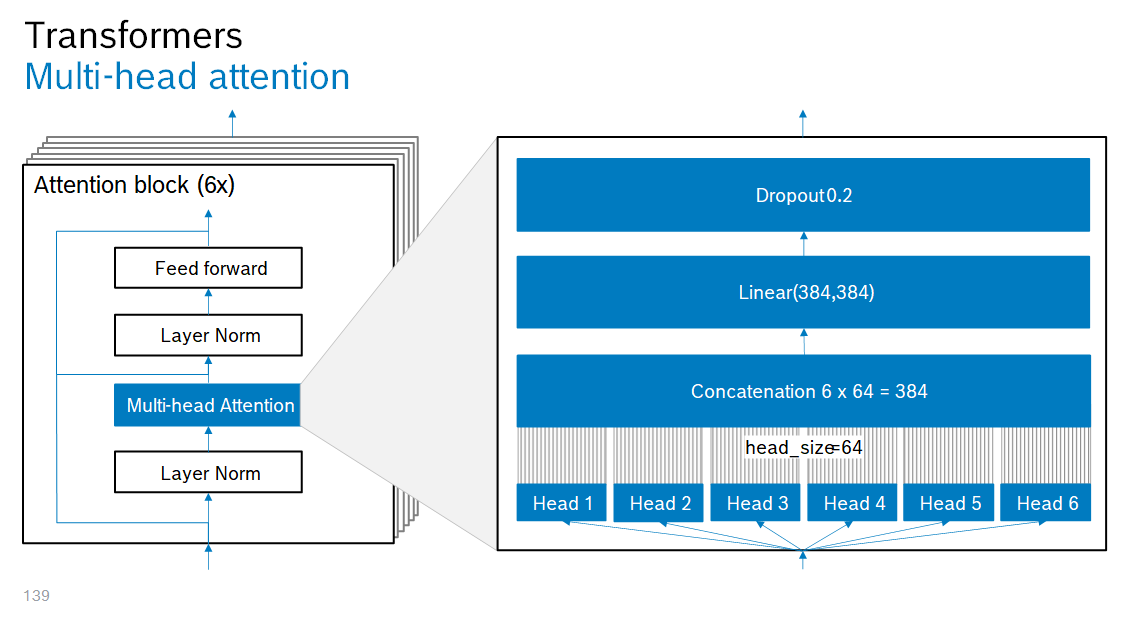

In [28]:
# Class that bundles 6 attention heads

class MultiHeadAttention(nn.Module):
    """ Six heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Just a container
        self.weighting = nn.Linear(n_embd, n_embd) # Linear layer to weight the attention heads
        self.dropout = nn.Dropout(dropout) # Prevent overfitting

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Feed parallel attention heads and concatenate results
        out = self.dropout(self.weighting(out)) # Weighting the attention head results and dropout
        return out


# Feed forward

The Feed forward layer in the Attention block consists of four steps. Therefore, we define it as its own class.

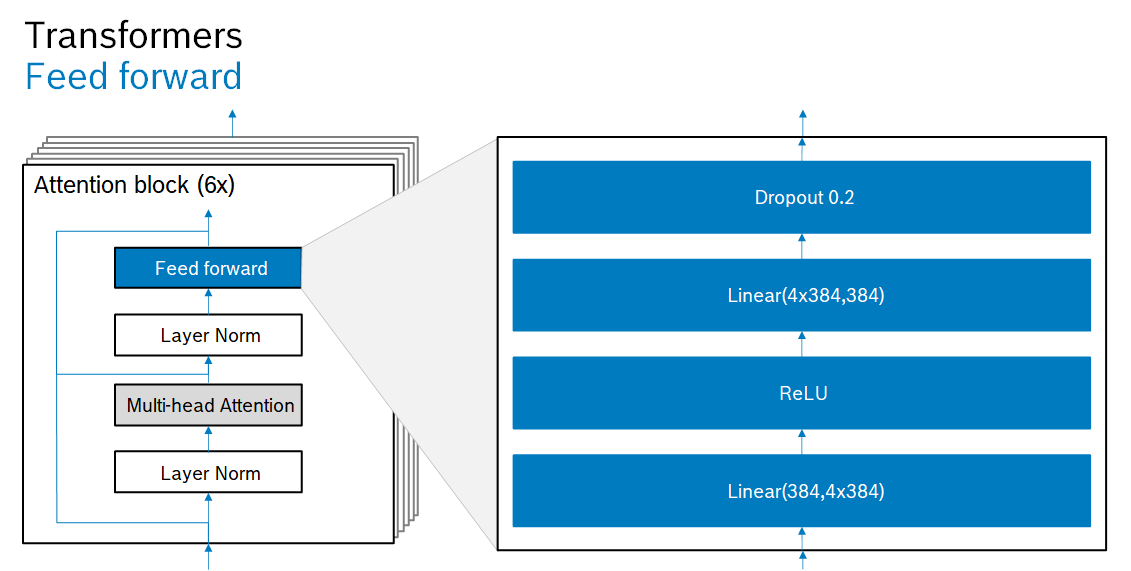

In [29]:
# A linear layer for general calculation purpose

class FeedForward(nn.Module):
    """ Simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(           # Sequence of steps
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout))

    def forward(self, x):
        return self.net(x)


# Attention block

Now we are prepared to put all attention components together and build the attention block.

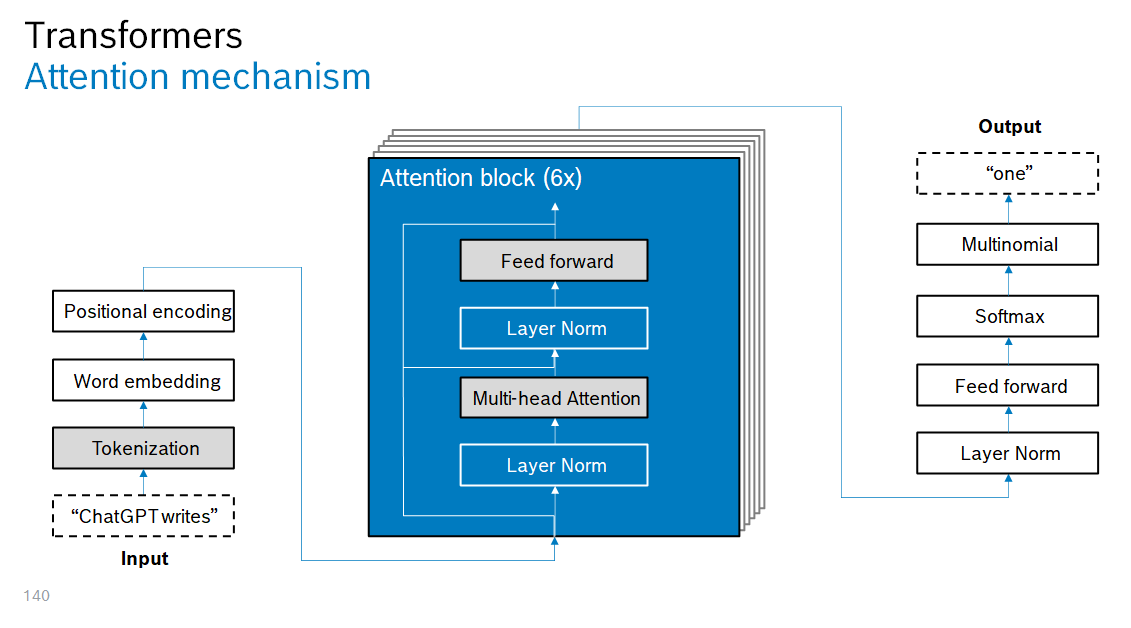

In [30]:
# Only one run-through. Loop is specified in the Transformer class

class Block(nn.Module):
    """ Attention block """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head # Free dimension of key, query and value matrices
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Residual/skip connection
        x = x + self.ffwd(self.ln2(x)) # Residual/skip connection
        return x


# Transformer (Putting all together)

Finally, we assemble all parts in a class which we call meaningfully Transformer. In the forward run we pass the data through the final feed forward layer and stop before softmax. This is primarily used in training loops.

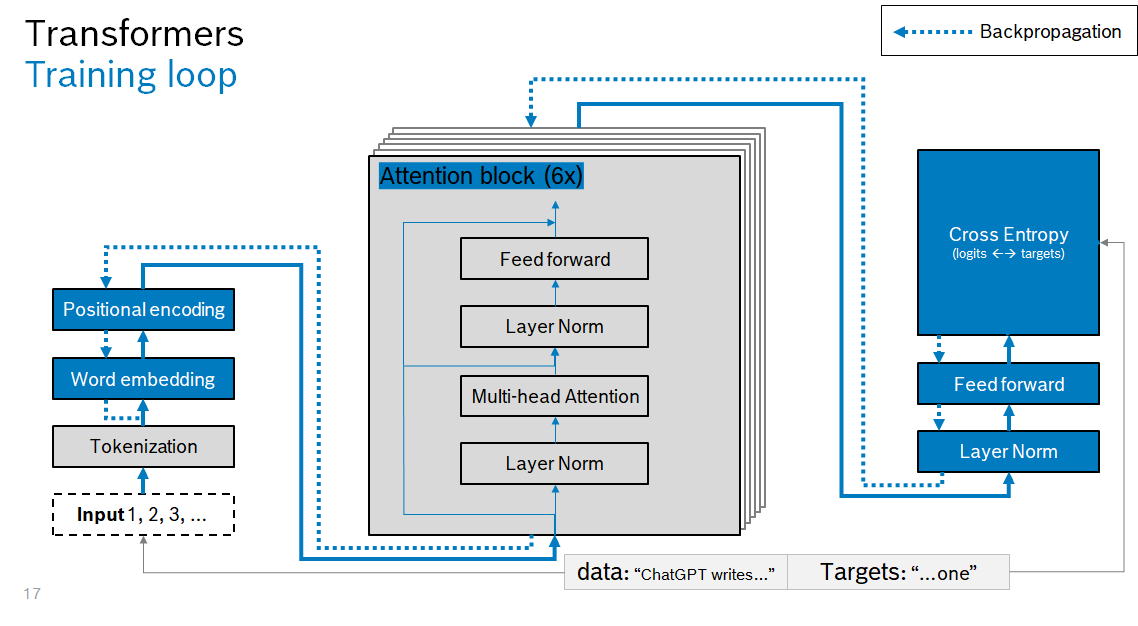

In a generation run we go two steps further and pass the data through softmax and finally sample from a multinomial distribution. This gives us the next token as our output.

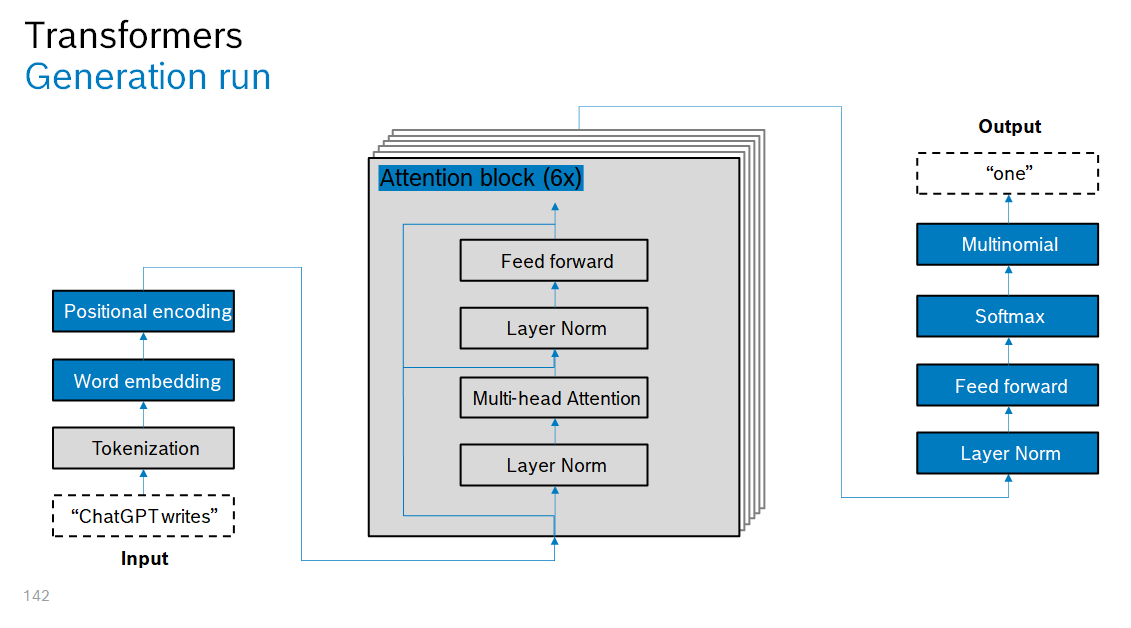

In the final feed forward layer we scale the embedding dimension to the vocabulary size in order to receive a probability value for each token to be the next one for outputting:

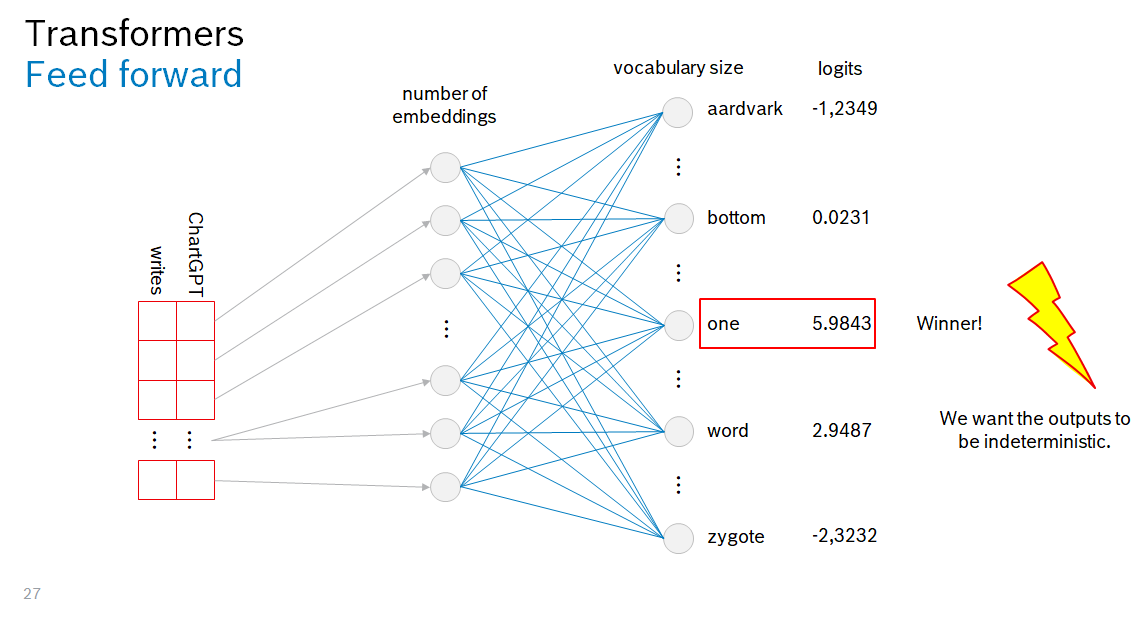

In [31]:
# More hyperparameters
n_head = 6 # Number of heads in multi-head attention
n_layer = 6 # Number of attention blocks

# Main class embracing all modules
class Transformer(nn.Module):

    # When we initialize an instance from the Transformer class
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # Word/token embedding
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # Positional embedding
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # Stack of attention blocks
        self.final_ln = nn.LayerNorm(n_embd) # Final layer norm
        self.final_ff = nn.Linear(n_embd, vocab_size) # Final linear layer

    # When we run an instance of the Transformer class
    def forward(self, input, targets=None): # input and targets are both (B,T)-dimensional tensors of integers
        
        B, T = input.shape # Dimensions of input data: batch x tokens
        tok_emb = self.token_embedding_table(input) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C), Python automatically adds dimension B to pos_emb
        x = self.blocks(x) # (B,T,C)
        x = self.final_ln(x) # (B,T,C)
        logits = self.final_ff(x) # (B,T,vocab_size

        # Only if targets are defined --> loss calculation
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape # Get dimensions of output
            logits = logits.view(B*T, C) # Transform to two dimensions for cross_entropy function
            targets = targets.view(B*T)  # Transform to two dimensions for cross_entropy function
            loss = F.cross_entropy(logits, targets) # Calculate the losses

        return logits, loss

    # When we generate new text
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) tensor of indices
        for _ in range(max_new_tokens): # Concatenate max_new_tokens outputs
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # Get the predictions
            logits, loss = self.forward(idx_cond)
            # Focus only on the last token
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
        

# Instantiate the Transformer

In [32]:
# Instantiate an object from the Transformer class
model = Transformer().to(device) # 'model' lives in the device, in my case the GPU

# Print the number of parameters in the model
print(format(sum(p.numel() for p in model.parameters()),","), 'parameters')


10,788,929 parameters


# Generate new tokens

In [33]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
untrained_results = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(untrained_results)


SaVVul&f&&;gXKUPZo-TRZ$LgFqlHpkPkBj!'BTSbOXDynYi.t3:U.nwO.mkMHKRP;wqkjwe nwReYPVP!AAyC,hbbJIbOUIGEf-.Ca-!ZorYHZo-CZcnYkwkQu'Ww3WvxFxwFhRZI.LINfmKKQOxmy
Ib,;OllE?maEwTcGoq'ulxHmshIbPU!-JTYrcXwFzqhgtG&aykVSD,KD?R, zpZyR.D:FB-C:Xmt.-'JJ.soQ!A$D;;phlfbSqNlLQm;b
oSDxtd&GuN!:cEsTRxw,tHozPuYuQmiUVu;nIH,PxcGKBLwRm3Im$RJlRBckUJeqKIrqDJyp
K!nxWlfQax ,PwtgCAMYJ$;a3K!t,z3
NQF.yEaRwDcZRm MSiFRl-JoPB$xQTQDwuDsig-.eemDiNdm'gjRmq$JftPzxm'oto-rsBrMjwIXXyyro; PTumsy-cfUao dMA
Mire&ATQ,$SAesRhe'w
x$RG3SHim-TsQ&
s&


# Train the transformer model

Step 9999: train loss 1.1674, val loss 1.4751


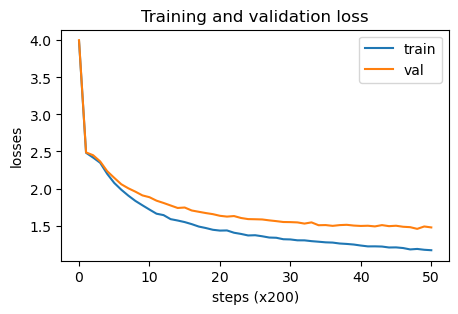

Test word generation:

Ln me't,' not become henceit, him made match: on
the boistable pacted by that heir merciance toward:


In [34]:
# More hyperparameters
eval_iters = 10 # How many interations do we average the loss calculation
learning_rate = 1e-4 # Step size for learning
max_iters = 10000 # Number of training loops
eval_interval = 200 # How often evaluate the model performance


# Function calculates losses and averages results over eval_interval values
@torch.no_grad() # Do not calculate any gradients for this function
def estimate_loss():
    out = {} # Empty dictionary for the results
    model.eval() # Set model to evaluation mode
    # Calculate loss for training and validaton data
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters) # Set to 0 for start
        for k in range(eval_iters): # 10 loops
            X, Y = get_batch(split) # Get training data
            logits, loss = model(X, Y) # Call model and get logits and losses
            losses[k] = loss.item()
        out[split] = losses.mean() # Save average under key 'train' or 'val'
    model.train() # Set model in training mode
    return out
    

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


# Empty lists of losses
loss_lst_train = []
loss_lst_val = []
loss_lst_x = []

# Train the model over max_iter loops
for iter in range(max_iters):

    # Get a batch of training data
    xb, yb = get_batch('train')
    
    # Run the transformer model
    logits, loss = model(xb, yb)

    # Zero the gradients
    optimizer.zero_grad(set_to_none=True)

    # Calculate the gradients
    loss.backward()

    # Optimizes parameters through backpropagation
    optimizer.step()
    
    # Evaluate and print losses
    if iter % eval_interval == 0 or iter == max_iters - 1:
        
        # Caluculate losses
        losses = estimate_loss() # Call evaluation 
        loss_lst_train.append(losses['train'].item())          # Append to training list
        loss_lst_val.append(losses['val'].item())              # Append to validaton list
        loss_lst_x = list(range(len(loss_lst_train)))    # Prepare the x values for plotting

        # Plot
        clear_output(wait=True)                                # Clear output in jupyter
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        plt.figure(figsize=(5,3))
        plt.plot(loss_lst_x,loss_lst_train,label='train')
        plt.plot(loss_lst_x,loss_lst_val,label='val')
        plt.xlabel('steps (x' + str(eval_interval) + ')')
        plt.ylabel('losses')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

        # Do a test generation to observe the quality
        print('Test word generation:')
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))


# Save the model


In [35]:
torch.save(model.state_dict(), 'Shakespeare_char_10k_new.pth')

# Load the `state_dict` into the transformer model

We can save and load the model's parameters into a `state_dict`. Here, we load the parameters from an earlier training with 10k cycles.

In [36]:
# Load the saved model state

state_dict = torch.load('Shakespeare_char_10k.pth')

# Load the parameters into the transformer model
model.load_state_dict(state_dict)

<All keys matched successfully>

# Generate new tokens

## Generate from starting index

In [37]:
# Print output from before training
print('Model output before training:')
print(untrained_results)

# Print output after training
context = torch.zeros((1, 1), dtype=torch.long, device=device)
trained_results = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print('\nModel output after training:')
print(trained_results)

Model output before training:

SaVVul&f&&;gXKUPZo-TRZ$LgFqlHpkPkBj!'BTSbOXDynYi.t3:U.nwO.mkMHKRP;wqkjwe nwReYPVP!AAyC,hbbJIbOUIGEf-.Ca-!ZorYHZo-CZcnYkwkQu'Ww3WvxFxwFhRZI.LINfmKKQOxmy
Ib,;OllE?maEwTcGoq'ulxHmshIbPU!-JTYrcXwFzqhgtG&aykVSD,KD?R, zpZyR.D:FB-C:Xmt.-'JJ.soQ!A$D;;phlfbSqNlLQm;b
oSDxtd&GuN!:cEsTRxw,tHozPuYuQmiUVu;nIH,PxcGKBLwRm3Im$RJlRBckUJeqKIrqDJyp
K!nxWlfQax ,PwtgCAMYJ$;a3K!t,z3
NQF.yEaRwDcZRm MSiFRl-JoPB$xQTQDwuDsig-.eemDiNdm'gjRmq$JftPzxm'oto-rsBrMjwIXXyyro; PTumsy-cfUao dMA
Mire&ATQ,$SAesRhe'w
x$RG3SHim-TsQ&
s&

Model output after training:

And KIFORD III:
Romeo;
Thy after more than a great maid, take
My leave to her strupke me to death,
Thou shalt writ.

LUCIO:
Hang?

DUKE MARD:
Art thou wert many I awon.

LEONTES:
Pardon, I, I have take her dead of manite,
In birth, by the marvelless in mine earn'd;
Because not calls to be slanderous by,
Or be abbasemed: offence, and histers your ghor
Than it corn doing our men than you mind all.
He manster to thirty off you, some may

## Generate from starting sentence

In [38]:
# Encode a starting sentence
text = "INGO:\nI am your master!"
context = encode(text)
print(context)

[21, 26, 19, 27, 10, 0, 21, 1, 39, 51, 1, 63, 53, 59, 56, 1, 51, 39, 57, 58, 43, 56, 2]


In [39]:
# Load context into tensor
context_tensor = torch.tensor([context], dtype=torch.long, device=device)
context_tensor.shape

torch.Size([1, 23])

In [40]:
print(decode(model.generate(context_tensor, max_new_tokens=500)[0].tolist()))

INGO:
I am your master!

LUCIO:
But, I am awhile.

TYRREL:
George, I had be born in tear; the son, young break me
safest not of you.

YORK:
Whither I have bided, as he shall hear.

DUKE VINCENTIO:
What's your genewoman? then, by so eveny:
Being some coming thus cannot, when you dare near:
I have heard conjure I would live me: determs
Are you he both's can fit you.

PERDITA:
Enough morrow
Condemne. Look of our venate, an ot Withal conwer?

Roman:
Thou hast wilt truth quickles. Tush AUTor Jove we gone.

ESCALUS:
Sir, th
